数据降维
===

# 1.概述
高维数据集有很大风险分布的非常稀疏：大多数训练实例可能彼此远离。当然，这也意味着一个新实例可能远离任何训练实
例，这使得预测的可靠性远低于我们处理较低维度数据的预测，因为它们将基于更大的推测。简而言之，训练集的维度越
高，过拟合的风险就越大。理论上来说，维数爆炸的一个解决方案是增加训练集的大小从而达到拥有足够密度的训练集。不
幸的是，在实践中，达到给定密度所需的训练实例的数量随着维度的数量呈指数增长本部分包含三个内容，线性判别分析-
LDA、主成分分析-PCA、奇异值分解-SVD等等，本节我们通过对瑞士卷的降维来学习一下这些方法

Text(0.5,0.92,'Original data')

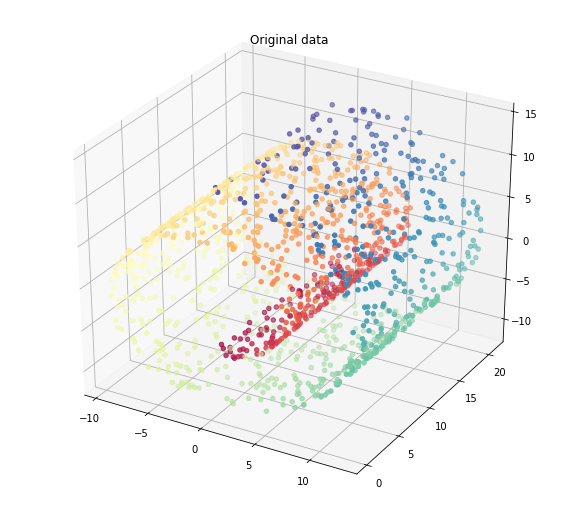

In [2]:
from sklearn import datasets,manifold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12,
                                             n_components=2)
fig = plt.figure(figsize=(10,20))

ax = fig.add_subplot(2,1,1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

# 2.线性判别分析(LDA,Linear Discriminant Analysis)
## 2.1.LDA的分类思想
LDA是一种有监督的降维技术，也就是说它的数据集的每个样本是有类别输出的。有些资料上也称为是Fisher’s Linear 
Discriminant。LDA的思想可以用一句话概括，就是“投影后类内方差最小，类间方差最大”，也就是说要将数据在低维度上进
行投影，投影后希望每一种类别数据的投影点尽可能的接近，而不同类别的数据的类别中心之间的距离尽可能的大
1. 对于多维空间中的数据处理分类问题较为复杂，LDA算法将多维空间中的数据投影到一条直线上，将d维数据转化为1维
数据进行处理
2. 对于训练数据，设法将多维数据投影到一条直线上，是的同类数据的投影点尽可能接近，异类数据点尽可能远离
3. 在对新数据进行分类时，将其投影到同样的这条直线上，再根据投影点的位置来确定样本的类别

线性判别分析就是将样例投影到一条直线上，使得同类的样例投影点尽可能小，不同类投影点尽可能远离

## 2.2.投影直线的确定
### 2.2.1.问题给出
> 假设我们的数据集$D=\\{(x_1,y_1),(x_2,y_2),...,(x_m,y_m)\\}$，其中任意样本$x_i$为n维向量，$y_i \in \\{0,1\\}$。我们有四个定义如下表

| 公式 | 定义 | 表达式 |
| :--- | :--- | :----- |
| $N_j(j=0,1)$ | 第j类样本的个数 | - |
| $X_j(j=0,1)$ | 第j类样本的集合 | - |
| $\mu_j(j=0,1)$ | 第j类样本的均值向量 | $\frac{1}{N_j}\sum_{x \in X_j}x$, 其中$j=0,1$ |
| $\sum_j(j=0,1)$ | 第j类样本的协方差矩阵(严格说是缺少分母部分的协方差矩阵) | $\sum_{x \in X_j}(x-\mu_j)(x-\mu_j)^T$,其中$j=0,1$ |

### 2.2.2.优化目标
由于有两类数据，因此我们只需要将数据投影到一条直线上即可。假设我们的投影直线是向量$\omega$，则对任意一个样本$x_i$，它
的直线投影为$\omega^Tx_i$，对于我们的两个类别的中心点$\mu_0,\mu_1$,在直线上的投影为$\omega^T\mu_0$和$\omega^T\mu_1$。于LDA需要让不同类别的数据
的类别中心之间的距离尽可能的大，也就是我们要最大化$||\omega^T\mu_0-\omega^T\mu_1||_2^2$,同时我们希望同一类别数据的投影点尽可能的
接近，也就是要同类样本投影点的协方差$\omega^T\sum_0\omega$和$\omega^T\sum_1\omega$尽可能的小，也就是最小化$\omega^T\sum_0\omega + \omega^T\sum_1\omega$，那我们
的优化目标为
$$
argmax_{\omega}J(\omega)=\frac{||\omega^T\mu_0-\omega^T\mu_1||_2^2}{\omega^T\sum_0\omega + \omega^T\sum_1\omega}=\frac{\omega^T(\mu_0-\mu_1)(\mu_0-\mu_1)^T\omega}{\omega^T(\sum_0+\sum_1)\omega}
$$

### 2.2.3.散度矩阵
我们一般定义类内散度矩阵$S_{\omega}$为
$$S_{\omega}=\sum_0+\sum_1=\sum_{x \in X_0}(x-\mu_0)(x-\mu_0)^T + \sum_{x \in X_1}(x-\mu_1)(x-\mu_1)^T$$
同时定义类间散度矩阵$S_b$为
$$S_b=(\mu_0-\mu_1)(\mu_0-\mu_1)^T$$
那我们的优化目标重写为
$$
argmax_{\omega}J(\omega)=\frac{\omega^TS_b\omega}{\omega^TS_{\omega}\omega}
$$

### 2.2.4.瑞利商(Rayleigh quotient)
瑞利商是指这样的函数$R(A,x)=\frac{x^HAx}{x^Hx}$，其中$x$为非零向量，而A为n*n的Hermitan矩阵。所谓Hermitan举着就是满足共轭
转置矩阵和自己相等的矩阵，即$A^H=A$，如果我们的矩阵A是实矩阵，则满足$A^T=A$的矩阵即为Hermitan矩阵。瑞利商
$R(A,x)$有一个非常重要的性质，即它的最大值等于矩阵A最大的特征值，而最小值等于矩阵A的最小特征值，也就是满足
$$
\lambda_{min} \leq \frac{x^HAx}{x^Hx} \leq \lambda_{max}
$$
当向量x是标准正交基时，即满足$x^Hx=1$时，瑞利商退化为$R(A,x)=x^HAx$，这个形式在谱聚类和PCA中都有出现

### 2.2.5.广义瑞利商(Generalized Rayleigh quotient)
广义瑞利商是指这样的函数$R(A,B,x)=\frac{x^HAx}{x^HBx}$,其中x为非零向量，而A,B为n×n的Hermitan矩阵,B为正定矩阵。只要通过
将其通过标准化就可以转化为瑞利商的格式，我们就能求解。我们令$x′=B^{-\frac{1}{2}}x$,则分母转化为
$$
x^HBx=x'^H(B^{-\frac{1}{2}})^HBB^{-\frac{1}{2}}x'=x'^HB^{-\frac{1}{2}}BB^{-\frac{1}{2}}x'=x'^Hx'
$$
分子转化为
$$
x^HAx=x'^HB^{-\frac{1}{2}}AB^{-\frac{1}{2}}x'
$$
此时我们的$R(A,B,x)$转化为$R(A,B,x')$
$$R(A,B,x')=\frac{x'^HB^{-\frac{1}{2}}AB^{-\frac{1}{2}}x'}{x'^Hx'}$$
利用前面的瑞利商的性质，我们可以很快的知道，$R(A,B,x)$的最大值为矩阵$B^{-\frac{1}{2}}AB^{-\frac{1}{2}}$的最大特征值，或者说矩阵
$B^{-1}A$的最大特征值，而最小值为$B^{-1}A$的最小特征值

### 2.2.6.二类LDA问题求解
我们看到最后的目标函数，一看就知道是广义瑞利商，那么$J(\omega)$的最大值就是$S_{\omega}^{-1}S_b$的最大特征值，而对应的$\omega$为$S_{\omega}^{-1}S_b$
的最大特征值对应的特征向量。注意到对于二类的时候，$S_b\omega$的方向恒为$\mu_0-\mu_1$，不妨令$S_b\omega=\lambda(\mu_0-\mu_1)$，将其带入
$(S_{\omega}^{-1}S_b)\omega=\lambda\omega$，可以得到$\omega=S_{\omega}^{-1}(\mu_0-\mu_1)$，也就是说我们只要求出原始而类样本的均值和方差就可以确定最佳的投
影方向$\omega$了

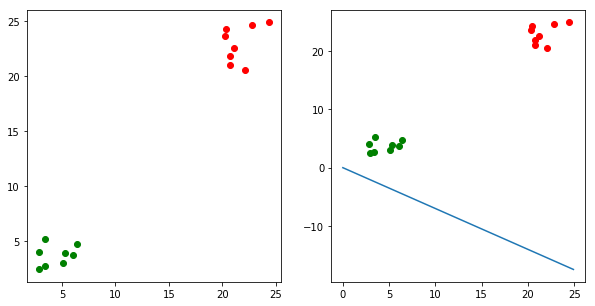

In [5]:
import os
import sys
import numpy as np
import operator
import matplotlib.pyplot as plt
from numpy import mat

%matplotlib inline
group1 = np.random.random((8,2))*5+20
group2 = np.random.random((8,2))*5+2
X1 = group1
y1 = np.ones((8,1))
X0 = group2
y0 = np.zeros((8,1))
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(121)
plt.scatter(X1[:,0],X1[:,1],c='r')
plt.scatter(X0[:,0],X0[:,1],c='g')

mean1=np.array([np.mean(X1[:,0]),np.mean(X1[:,1])])
mean0=np.array([np.mean(X0[:,0]),np.mean(X0[:,1])])

m1=np.shape(X1)[0]
sw=np.zeros(shape=(2,2))
for i in range(m1):
    xsmean=mat(X1[i,:]-mean1)
    sw+=xsmean.transpose()*xsmean
m0=np.shape(X0)[0]
for i in range(m0):
    xsmean=mat(X0[i,:]-mean0)
    sw+=xsmean.transpose()*xsmean
w=(mean0-mean1)*(mat(sw).I)

plt.subplot(122)
plt.scatter(X1[:,0],X1[:,1],c='r')
plt.scatter(X0[:,0],X0[:,1],c='g')
x=np.arange(0,25,0.1)
y=np.array((-w[0,0]*x)/w[0,1])
plt.plot(x,y)

# 3.主成分分析(Principal Component Analysis, PCA)
LDA虽然可以进行数据降维，但是它的主要作用还是进行分类的。PCA主成分分析的主要作用则是进行数据降维。
## 3.1.数据降维
有时候，由于以下原因需要对数据进行简化:
- 使得数据集更容易使用
- 降低很多算法的计算开销
- 去除噪音
- 使得结果易懂

下面我们介绍数据降维的三种技术

## 3.2.因子分析(Factor Analysis)
- 通俗理解：将多个实测变量转换为少数几个综合指标。它反映一种降维的思想，通过降维将相关性高的变量聚在一起,从
而减少需要分析的变量的数量,而减少问题分析的复杂性
- 例如： 考察一个人的整体情况，就直接组合3样成绩(隐变量)，看平均成绩就行(存在：数学、语文、英语成绩)
- 应用的领域：社会科学、金融和其他领域
- 在因子分析中，我们
- 假设观察数据的成分中有一些观察不到的隐变量(latent variable)。
- 假设观察数据是这些隐变量和某些噪音的线性组合。
- 那么隐变量的数据可能比观察数据的数目少，也就说通过找到隐变量就可以实现数据的降维。

## 3.3.独立成分分析(Independ Component Analysis, ICA)
- 通俗理解：ICA 认为观测信号是若干个独立信号的线性组合，ICA 要做的是一个解混过程。
- 例如：我们去ktv唱歌，想辨别唱的是什么歌曲？ICA 是观察发现是原唱唱的一首歌[2个独立的声音(原唱／主唱)]。
- ICA是假设数据是从N个数据源混合组成的，这一点和因子分析有些类似，这些数据源之间在统计上是相互独立的，而在
PCA中只假设数据是不相关（线性关系）的。
- 同因子分析一样，如果数据源的数目少于观察数据的数目，则可以实现降维过程。

## 3.4.主成分分析(PCA)
- 通俗理解：就是找出一个最主要的特征，然后进行分析。例如： 考察一个人的智力情况，就直接看数学成绩就行(存
在：数学、语文、英语成绩)

PCA的应用目前最为广泛

### 3.4.1.原理
1. 找出第一个主成分的方向，也就是数据方差最大的方向。
2. 找出第二个主成分的方向，也就是数据方差次大的方向，并且该方向与第一个主成分方向 正交(orthogonal如果是二维空
间就叫垂直)。
3. 通过这种方式计算出所有的主成分方向。
4. 通过数据集的协方差矩阵及其特征值分析，我们就可以得到这些主成分的值。
5. 一旦得到了协方差矩阵的特征值和特征向量，我们就可以保留最大的N个特征。这些特征向量也给出了N个最重要特征的
真实结构，我们就可以通过将数据乘上这 N 个特征向量 从而将它转换到新的空间上。

## 3.5.通过PCA对瑞士卷进行降维

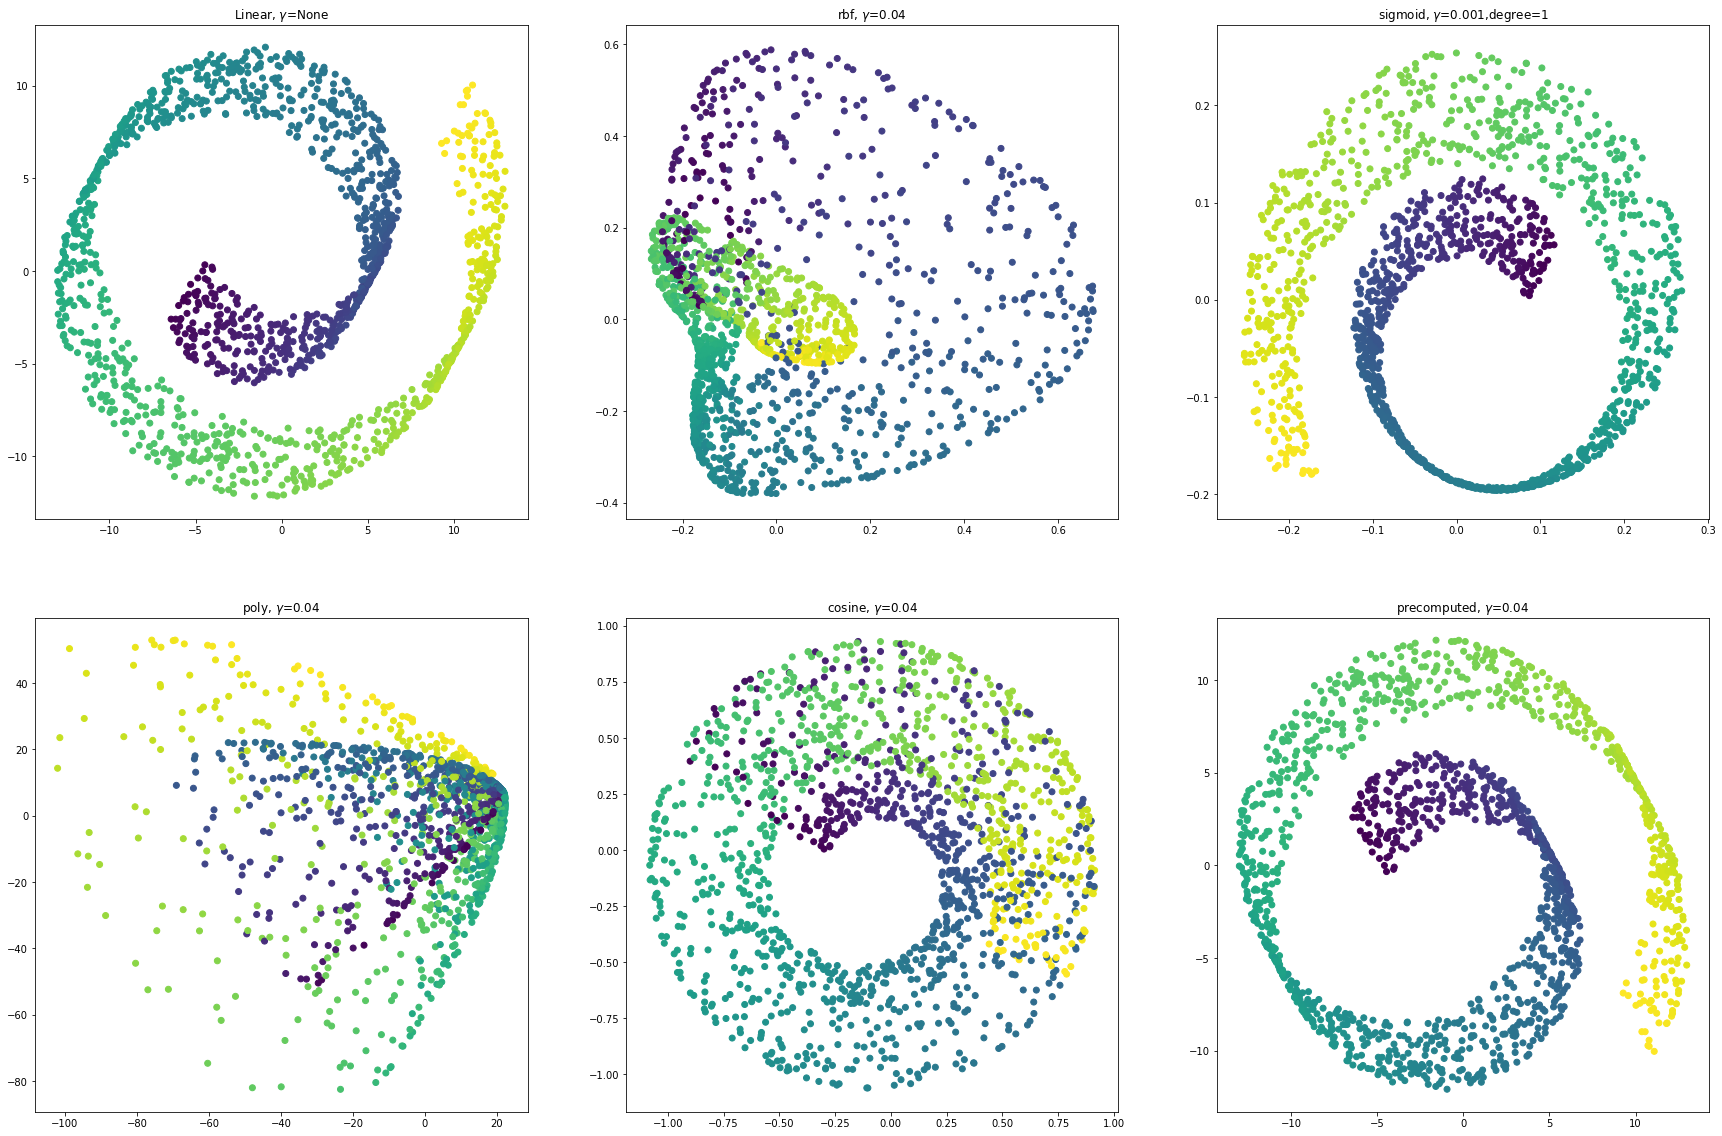

In [4]:
from sklearn.decomposition import KernelPCA
import numpy as np

plt.figure(figsize=(30,20), facecolor='w')
plt.subplot(2,3,1)
plt.title('Linear, $\gamma$=None')
pca = KernelPCA(n_components=2, kernel='linear')
x_linear = pca.fit_transform(X)
plt.scatter(x_linear[:,0], x_linear[:, 1], c = color)

plt.subplot(2,3,2)
plt.title('rbf, $\gamma$=0.04')
pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
x_rbf = pca.fit_transform(X)
plt.scatter(x_rbf[:,0], x_rbf[:, 1], c = color)

plt.subplot(2,3,3)
plt.title('sigmoid, $\gamma$=0.001,degree=1')
pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, degree=1)
x_sigmoid = pca.fit_transform(X)
plt.scatter(x_sigmoid[:,0], x_sigmoid[:, 1], c = color)

plt.subplot(2,3,4)
plt.title('poly, $\gamma$=0.04')
pca = KernelPCA(n_components=2, kernel='poly', gamma=0.04)
x_poly = pca.fit_transform(X)
plt.scatter(x_poly[:,0], x_poly[:, 1], c = color)

plt.subplot(2,3,5)
plt.title('cosine, $\gamma$=0.04')
pca = KernelPCA(n_components=2, kernel='cosine', gamma=0.04)
x_cosine = pca.fit_transform(X)
plt.scatter(x_cosine[:,0], x_cosine[:, 1], c = color)

plt.subplot(2,3,6)
plt.title('precomputed, $\gamma$=0.04')
pca = KernelPCA(n_components=2, kernel='precomputed', gamma=0.04)
x_precomputed = pca.fit_transform(np.dot(X, X.T))
plt.scatter(x_precomputed[:,0], x_precomputed[:, 1], c = color)

#4.奇异值分解(SVD)
## 4.1.概述
奇异值分解是提取信息的一种方法，可以把SVD看成是从噪声数据中抽取相关特征。从生物信息学到金融学，SVD是提取信
息的强大工具。

## 4.2.应用场景
### 4.2.1.信息检索

### 4.2.2.推荐系统
- 利用 SVD 从数据中构建一个主题空间
- 再在该空间下计算其相似度。(从高维-低维空间的转化，在低维空间来计算相似度，SVD 提升了推荐系统的效率)

# 5.局部线性嵌入(LLE)
局部线性嵌入（Locally Linear Embedding）是另一种非常有效的非线性降维（NLDR）方法。这是一种流形学习技术，不依赖于像以前算法那样的投影。简而言之，LLE 首先测量每个训练实例与其最近邻（c.n.）之间的线性关系，然后寻找能最好地保留这些局部关系的训练集的低维表示（稍后会详细介绍） 。这使得它特别擅长展开扭曲的流形，尤其是在没有太多噪音的情况下。

## 5.1.工作原理
### 5.1.1.第一步
对于每个训练实例$x^{(i)}$,找到其最近的K个邻居，然后尝试将$x^{(i)}$重构为这些邻居的线性函数。更具体的，找到权重$\omega_{i,j}$，使得$x^{(i)}$和$\sum_{j=1}^m\omega_{i,j}x^{(j)}$之间的平方距离尽可能的小。假设如果$x^{(j)}$不是$x^{(i)}$的k个最近邻时$\omega_{i,j}=0$。建模后有如下条件：
$$
\hat{\Omega}=argmin_{\Omega}\sum_{i=1}^m||x^{(i)}-\sum_{j=1}^m\omega_{i,j}x^{(j)}||^2
$$
约束条件为
$$SubjectTo=\begin{split}
\omega_{i,j}&=0 \\\\
\sum_{j=1}^m\omega_{i,j}&=1,i=1,2,...,m
\end{split}$$
条件一的成立条件是$x^{(j)}$不是$x^{(i)}$的K个邻居，条件二是对每个训练实例的权重进行了归一化

### 5.1.2.第二步
将训练实例投影到一个d维空间(d < n)中去，同时尽可能的保留这些局部关系。如果$z^{(i)}$是$x^{(i)}$在这个d维空间的图像，那么我们想要$z^{(i)}$和$\sum_{j=1}^{m}\hat{w_{i,j}}\ z^{(j)}$之间的平方距离尽可能的小。请注意，Z是包含所有$z^{(i)}$的矩阵。
$$
\hat{Z}=argmin_{Z}\sum_{i=1}^m||z^{(i)}-\sum_{j=1}^{m}\hat{w_{i,j}}z^{(j)}||^2
$$


## 5.2.通过LLE对瑞士卷进行降维

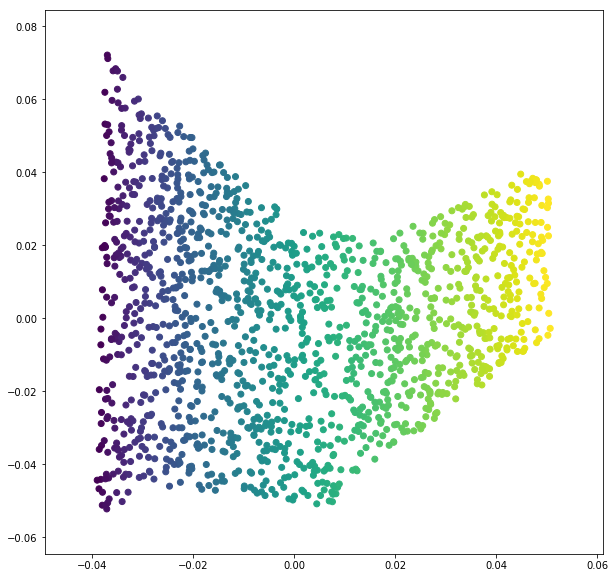

In [6]:
from sklearn.manifold import LocallyLinearEmbedding

plt.figure(figsize=(10,10), facecolor='w')
lle=LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_LLE=lle.fit_transform(X)
plt.scatter(X_LLE[:,0], X_LLE[:, 1], c = color)

# 6.多位缩放(MDS)
尝试保持实例之间距离的同时降低了维度

# 7.ISOMAP
通过将每个实例连接到最近的邻居来创建图形，然后在尝试保持实例之间的测地距离时降低维度。

# 7.ISOMAP
通过将每个实例连接到最近的邻居来创建图形，然后在尝试保持实例之间的测地距离时降低维度。

# 8.t-分布随机邻域嵌入(t-Distributed Stochastic Neighbor Embedding，t-SNE)
可以用于降低维​​度，同时试图保持相似的实例临近并将不相似的实例分开。它主要用于可视化，尤其是用于可视化高维空间中的实例

# 8.t-分布随机邻域嵌入(t-Distributed Stochastic Neighbor Embedding，t-SNE)
可以用于降低维​​度，同时试图保持相似的实例临近并将不相似的实例分开。它主要用于可视化，尤其是用于可视化高维空间中的实例

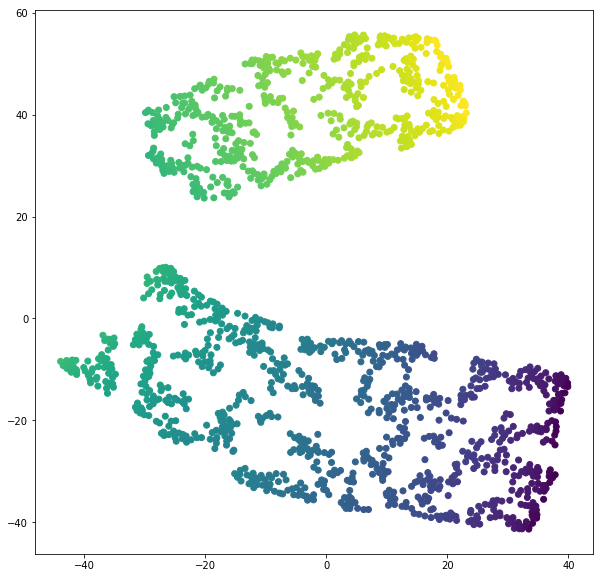

In [17]:
from sklearn.manifold import TSNE
plt.figure(figsize=(10,10), facecolor='w')
tsne=TSNE(n_components=2)
X_TSNE=tsne.fit_transform(X)
plt.scatter(X_TSNE[:,0], X_TSNE[:, 1], c = color)

## 3.2.因子分析(Factor Analysis)
- 通俗理解：将多个实测变量转换为少数几个综合指标。它反映一种降维的思想，通过降维将相关性高的变量聚在一起,从
而减少需要分析的变量的数量,而减少问题分析的复杂性
- 例如： 考察一个人的整体情况，就直接组合3样成绩(隐变量)，看平均成绩就行(存在：数学、语文、英语成绩)
- 应用的领域：社会科学、金融和其他领域
- 在因子分析中，我们
- 假设观察数据的成分中有一些观察不到的隐变量(latent variable)。
- 假设观察数据是这些隐变量和某些噪音的线性组合。
- 那么隐变量的数据可能比观察数据的数目少，也就说通过找到隐变量就可以实现数据的降维。